# Линейная регрессия
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [1]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

In [2]:
def read_data(path="boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    np.random.seed(42)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [3]:
def generate_synthetic(size:int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [4]:
def mse(y_true:np.ndarray, y_predicted:np.ndarray):
    return np.mean((y_true - y_predicted) ** 2)

def r2(y_true:np.ndarray, y_predicted:np.ndarray):
    u, v = 0, 0
    yy = np.mean(y_true)
    for yt, yp in zip(y_true, y_predicted):
        u += (yp - yt) ** 2
        v += (yy - yt) ** 2
    return 1 - u/v

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [5]:
class NormalLR:
    def __init__(self):
        self.w = None
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        X_new = np.hstack((X, np.ones((X.shape[0], 1))))
        self.w = np.dot(np.dot(np.linalg.inv(np.dot(X_new.T, X_new)), X_new.T), y)
    
    def predict(self, X:np.ndarray) -> np.ndarray:
        return np.dot(np.hstack((X, np.ones((X.shape[0], 1)))), self.w)

In [6]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [7]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.011424973900095147, R2: 0.9990365269412725


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [123]:
class GradientLR:
    def __init__(self, alpha:float, iterations=10000, l=0.):
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
        self.w = None
        self.min = None
        self.max = None
        self.miny = None
        self.maxy = None
    
    def fit(self, X: np.ndarray, y: np.ndarray):
        X_new = np.hstack((X, np.ones((X.shape[0], 1))))
        self.min = np.amin(X_new, axis=0)
        self.max = np.amax(X_new, axis=0)
        X_new -= self.min
        X_new = np.divide(X_new, self.max - self.min, out=np.zeros_like(X_new), where=self.max - self.min!=0)
        self.miny = np.min(y)
        self.maxy = np.max(y)
        y_new = y - self.miny
        y_new = np.divide(y_new, self.maxy - self.miny, out=np.zeros_like(y), where=self.maxy - self.miny!=0)
        self.w = np.random.randn(X_new.shape[1])
        dw = np.zeros(X_new.shape[1])
        for _ in range(self.iterations):
            y_pred = np.dot(X_new, self.w)
            dw = - (2 * np.dot(y_new - y_pred, X_new)) / X.shape[0] + self.l * np.sign(self.w)
            self.w -= self.alpha * dw

    def predict(self, X: np.ndarray):
        X_new = np.hstack((X, np.ones((X.shape[0], 1))))
        X_new -= self.min
        X_new = np.divide(X_new, self.max - self.min, out=np.zeros_like(X_new), where=self.max - self.min!=0)
        return (np.dot(X_new, self.w)) * (self.maxy - self.miny) + self.miny

In [141]:
def build_plot(X_train, y_train, X_test, y_test):
    xs = np.arange(0.0, 0.002, 0.00002)
    errors = []
    for x in xs:
        regr = GradientLR(0.1, iterations=10000, l=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.show()

In [120]:
X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

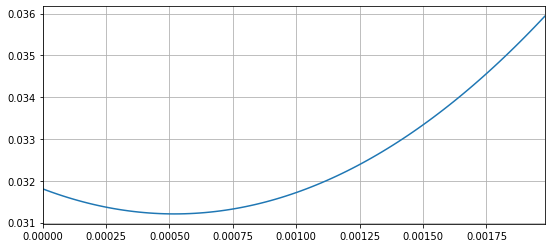

In [125]:
build_plot(X_train, y_train, X_val, y_val)

In [128]:
regr = GradientLR(0.1, iterations=10000, l=0.0005)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 0.031207172783147982, R2: 0.9796597258794395


### Задание 4 (2 балла)
Протесируйте оба метода на данных `boston.csv`, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [129]:
X, y = read_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=False)

In [130]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 22266311.080833532, R2: 0.6872797475661523


In [147]:
def build_plot(X_train, y_train, X_test, y_test):
    xs = np.arange(0.0, 0.004, 0.00004)
    errors = []
    for x in xs:
        regr = GradientLR(0.1, iterations=10000, l=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.show()

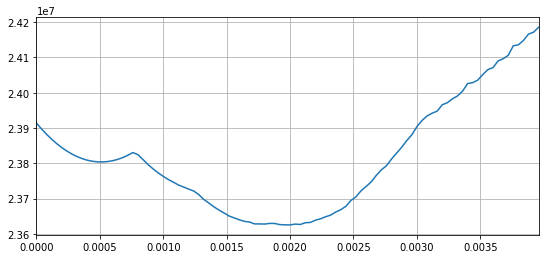

In [148]:
build_plot(X_train, y_train, X_val, y_val)

In [144]:
regr = GradientLR(0.1, iterations=30000, l=0.002)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 23624588.370128613, R2: 0.6682033583411251


### Задание 5 (2 балла)
Проинтерпритируйте полученные результаты. Опишите влияние каждого признака на результат предсказания.

In [143]:
regr.w

array([-1.23529594e-05,  4.68849809e-02, -8.42303756e-05,  4.83128143e-02,
       -5.73777646e-05,  7.17177556e-01,  1.77249418e-02, -4.96882632e-02,
        1.80924702e-02, -4.00341113e-02, -8.74761254e-02,  1.74834645e-01,
       -2.97916027e-01,  4.02307574e-05])

Получается, что больше всего на результат влияют признаки 6 и 13, то average number of rooms per dwelling и % lower status population, причём последнее с отрицательным весом, что логично при нахождении медианной цены домов, в которых живут хозяева. Значительно меньше на ответ влияют такие признаки как расстояния до основных мест работы, расстояние до кольцевых дорог, доступ к реке и не только. Наконец, минимальное значение имеют количество убийств на душу населения и признаки №3 и 5